In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


In [ ]:
test_path = '/kaggle/input/playground-series-s3e22/test.csv'
train_path = '/kaggle/input/playground-series-s3e22/train.csv'

In [ ]:
test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

In [ ]:
train = train.set_index('id')
test = test.set_index('id')

# **EDA**

In [ ]:
train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  nasogastr

In [ ]:
train.outcome.value_counts()

outcome
lived         574
died          410
euthanized    251
Name: count, dtype: int64

In [ ]:
target = ['outcome']

**Columns with Missing Values**

In [ ]:
train.isnull().sum()/len(train)

surgery                  0.000000
age                      0.000000
hospital_number          0.000000
rectal_temp              0.000000
pulse                    0.000000
respiratory_rate         0.000000
temp_of_extremities      0.031579
peripheral_pulse         0.048583
mucous_membrane          0.017004
capillary_refill_time    0.004858
pain                     0.035628
peristalsis              0.016194
abdominal_distention     0.018623
nasogastric_tube         0.064777
nasogastric_reflux       0.017004
nasogastric_reflux_ph    0.000000
rectal_exam_feces        0.153846
abdomen                  0.172470
packed_cell_volume       0.000000
total_protein            0.000000
abdomo_appearance        0.038866
abdomo_protein           0.000000
surgical_lesion          0.000000
lesion_1                 0.000000
lesion_2                 0.000000
lesion_3                 0.000000
cp_data                  0.000000
outcome                  0.000000
dtype: float64

In [ ]:
def columns_with_missing_values(df, percentage):
    columns_and_percentage = df.isnull().sum()/len(df)
    cols = df.columns
    columns_with_missing = []
    for i in range(0, len(cols)):
        if columns_and_percentage[i] > percentage:
            columns_with_missing.append(cols[i])
    return columns_with_missing

In [ ]:
cols_to_drop = columns_with_missing_values(train, 0.1)
cols_to_drop

['rectal_exam_feces', 'abdomen']

In [ ]:
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
num_cols_to_impute = columns_with_missing_values(train.select_dtypes(include='number'), 0)
num_cols_to_impute

[]

In [ ]:
def imputation_with_median(df, num_cols_to_impute):
    for col in num_cols_to_impute:
        df[col].fillna(df[col].median()[0], inplace=True)

In [ ]:
imputation_with_median(train, num_cols_to_impute)
imputation_with_median(test, num_cols_to_impute)

In [ ]:
cat_cols_to_impute = columns_with_missing_values(train.select_dtypes(exclude='number'), 0)
cat_cols_to_impute

['temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'pain',
 'peristalsis',
 'abdominal_distention',
 'nasogastric_tube',
 'nasogastric_reflux',
 'abdomo_appearance']

In [ ]:
def imputation_with_none(df, cat_cols_to_impute):
    for col in cat_cols_to_impute:
        df[col].fillna('None', inplace=True)

In [ ]:
imputation_with_none(train, cat_cols_to_impute)
imputation_with_none(test, cat_cols_to_impute)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1235 non-null   object 
 7   peripheral_pulse       1235 non-null   object 
 8   mucous_membrane        1235 non-null   object 
 9   capillary_refill_time  1235 non-null   object 
 10  pain                   1235 non-null   object 
 11  peristalsis            1235 non-null   object 
 12  abdominal_distention   1235 non-null   object 
 13  nasogastric_tube       1235 non-null   object 
 14  nasogastric_reflux     1235 non-null   object 
 15  nasogastr

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1235 to 2058
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    object 
 1   age                    824 non-null    object 
 2   hospital_number        824 non-null    int64  
 3   rectal_temp            824 non-null    float64
 4   pulse                  824 non-null    float64
 5   respiratory_rate       824 non-null    float64
 6   temp_of_extremities    824 non-null    object 
 7   peripheral_pulse       824 non-null    object 
 8   mucous_membrane        824 non-null    object 
 9   capillary_refill_time  824 non-null    object 
 10  pain                   824 non-null    object 
 11  peristalsis            824 non-null    object 
 12  abdominal_distention   824 non-null    object 
 13  nasogastric_tube       824 non-null    object 
 14  nasogastric_reflux     824 non-null    object 
 15  nasogas

In [ ]:
train.nunique()

surgery                    2
age                        2
hospital_number          255
rectal_temp               43
pulse                     50
respiratory_rate          37
temp_of_extremities        5
peripheral_pulse           5
mucous_membrane            7
capillary_refill_time      4
pain                       7
peristalsis                6
abdominal_distention       5
nasogastric_tube           4
nasogastric_reflux         5
nasogastric_reflux_ph     26
packed_cell_volume        49
total_protein             83
abdomo_appearance          4
abdomo_protein            54
surgical_lesion            2
lesion_1                  57
lesion_2                   4
lesion_3                   2
cp_data                    2
outcome                    3
dtype: int64

**Filtering Columns Based on Variance**

In [ ]:
train.select_dtypes(include='number').var()

hospital_number          1.839829e+12
rectal_temp              6.219968e-01
pulse                    8.473128e+02
respiratory_rate         2.706705e+02
nasogastric_reflux_ph    3.753351e+00
packed_cell_volume       1.110031e+02
total_protein            7.116331e+02
abdomo_protein           2.525542e+00
lesion_1                 2.955807e+07
lesion_2                 3.752191e+04
lesion_3                 7.895914e+03
dtype: float64

In [ ]:
def filtering_columns_based_on_variance(df, target, threshold):
    numeric = df.drop(target, axis=1).select_dtypes(include='number')
    num_and_var = numeric.var()
    numeric_cols = numeric.columns
    cols_witn_low_variance = []
    for i in range(0, len(numeric_cols)):
        if num_and_var[i] < threshold:   # variance threshold
            cols_witn_low_variance.append(numeric_cols[i])  
    return cols_witn_low_variance

In [ ]:
cols_witn_low_variance = filtering_columns_based_on_variance(train, target, 10)
cols_witn_low_variance

['rectal_temp', 'nasogastric_reflux_ph', 'abdomo_protein']

In [ ]:
train.drop(cols_witn_low_variance, axis=1, inplace=True)
test.drop(cols_witn_low_variance, axis=1, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1235 non-null   object 
 6   peripheral_pulse       1235 non-null   object 
 7   mucous_membrane        1235 non-null   object 
 8   capillary_refill_time  1235 non-null   object 
 9   pain                   1235 non-null   object 
 10  peristalsis            1235 non-null   object 
 11  abdominal_distention   1235 non-null   object 
 12  nasogastric_tube       1235 non-null   object 
 13  nasogastric_reflux     1235 non-null   object 
 14  packed_cell_volume     1235 non-null   float64
 15  total_pro

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1235 to 2058
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    object 
 1   age                    824 non-null    object 
 2   hospital_number        824 non-null    int64  
 3   pulse                  824 non-null    float64
 4   respiratory_rate       824 non-null    float64
 5   temp_of_extremities    824 non-null    object 
 6   peripheral_pulse       824 non-null    object 
 7   mucous_membrane        824 non-null    object 
 8   capillary_refill_time  824 non-null    object 
 9   pain                   824 non-null    object 
 10  peristalsis            824 non-null    object 
 11  abdominal_distention   824 non-null    object 
 12  nasogastric_tube       824 non-null    object 
 13  nasogastric_reflux     824 non-null    object 
 14  packed_cell_volume     824 non-null    float64
 15  total_p

**Filtering Highly Correlated Columns**

<Axes: >

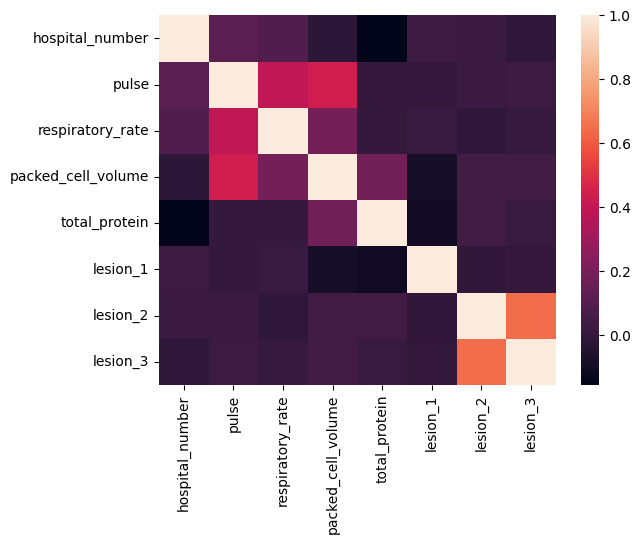

In [ ]:
sns.heatmap(train.select_dtypes(include='number').corr())

In [ ]:
def get_corr(df):
    feature_cols = df.columns[:]
    corr_values = df[feature_cols].corr()
    indexes = np.tril_indices_from(corr_values)
    for coord in zip(*indexes):
        corr_values.iloc[coord[0], coord[1]] = np.NaN
    corr_values = (corr_values.stack()
                   .to_frame()
                   .reset_index()
                   .rename(columns=
                           {'level_0':'feature1','level_1':'feature2', 0:'correlation'}))
    corr_values['abs_correlation'] = corr_values.correlation.abs()
    return corr_values.sort_values('abs_correlation', ascending=False)

In [ ]:
get_corr(train.select_dtypes(include='number')).query('abs_correlation>0.35')

,feature1,feature2,correlation,abs_correlation
27,lesion_2,lesion_3,0.644054,0.644054
8,pulse,packed_cell_volume,0.435102,0.435102
7,pulse,respiratory_rate,0.395130,0.395130


In [ ]:
cols_with_high_corr = ['lesion_2', 'pulse']

In [ ]:
train.drop(cols_with_high_corr, axis=1, inplace=True)
test.drop(cols_with_high_corr, axis=1, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   respiratory_rate       1235 non-null   float64
 4   temp_of_extremities    1235 non-null   object 
 5   peripheral_pulse       1235 non-null   object 
 6   mucous_membrane        1235 non-null   object 
 7   capillary_refill_time  1235 non-null   object 
 8   pain                   1235 non-null   object 
 9   peristalsis            1235 non-null   object 
 10  abdominal_distention   1235 non-null   object 
 11  nasogastric_tube       1235 non-null   object 
 12  nasogastric_reflux     1235 non-null   object 
 13  packed_cell_volume     1235 non-null   float64
 14  total_protein          1235 non-null   float64
 15  abdomo_ap

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1235 to 2058
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    object 
 1   age                    824 non-null    object 
 2   hospital_number        824 non-null    int64  
 3   respiratory_rate       824 non-null    float64
 4   temp_of_extremities    824 non-null    object 
 5   peripheral_pulse       824 non-null    object 
 6   mucous_membrane        824 non-null    object 
 7   capillary_refill_time  824 non-null    object 
 8   pain                   824 non-null    object 
 9   peristalsis            824 non-null    object 
 10  abdominal_distention   824 non-null    object 
 11  nasogastric_tube       824 non-null    object 
 12  nasogastric_reflux     824 non-null    object 
 13  packed_cell_volume     824 non-null    float64
 14  total_protein          824 non-null    float64
 15  abdomo_

**Pipeline**

In [ ]:
cat_columns = train.drop(target, axis=1).select_dtypes(exclude='number').columns
num_columns = train.drop(target, axis=1).select_dtypes(include='number').columns

In [ ]:
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
numerical_transformer = Pipeline(steps = [('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, num_columns),
    ('cat', categorical_transformer, cat_columns),
])

In [ ]:
y = train[target].values.ravel()
X_train = train.drop(target, axis=1)

In [ ]:
y

array(['died', 'euthanized', 'lived', ..., 'lived', 'lived', 'lived'],
      dtype=object)

# **Models**

**Random Forest**

RandomSearchCV

In [ ]:
# my_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
#                                ('model', RandomForestClassifier(random_state=42)
#                                )])

In [ ]:
# parameters = {'model__max_depth': range(1,15,2), 
#               'model__n_estimators': [30, 50, 100, 150, 170, 200, 210, 220, 250, 260, 300, 400, 500],
#               'model__max_depth': range(2,15,2),
#               'model__min_samples_split': range(2,15,2),
#               'model__min_samples_leaf': range(2,20,2),
#              }

# RandomSearchCV_clf = RandomizedSearchCV(my_pipeline, parameters, cv=5)
# RandomSearchCV_clf.fit(X_train, y)

In [ ]:
# my_pipeline.get_params().keys()

In [ ]:
# RandomSearchCV_clf.best_params_

Cross-validation

In [ ]:
# def get_score(my_pipeline, X_train, y, cv):
#     scores = cross_val_score(my_pipeline, X_train, y, cv=cv, scoring='f1_micro')
#     m = scores.mean()
#     print('Scores:')
#     for s in scores:
#         print(s)
#     print('Scores: {}'.format(m))

In [ ]:
# get_score(RandomSearchCV_clf.best_estimator_, X_train, y, 5)

In [ ]:
# RandomSearchCV_clf.best_estimator_.fit(X_train, y)

In [ ]:
# submission = test.copy()
# submission['outcome'] = RandomSearchCV_clf.best_estimator_.predict(test)
# submission.outcome.to_csv('submission.csv')

**XGBoost**

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                               ('model', XGBClassifier(random_state=42)
                               )])

In [ ]:
parameters = {'model__booster': ['gbtree', 'gblinear', 'dart'], 
              'model__eta': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
              'model__gamma': range(1,15,2),
              'model__max_depth': range(2,15,2),
              'model__min_child_weight': range(1,15,2),
              'model__max_delta_step': range(1,15,2),
              'model__subsample': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
              'model__n_estimators': [30, 50, 100, 150, 170, 200, 210, 220, 250, 260, 500, 1000],
              'model__n_features': [30, 50, 100, 150, 170, 200, 210, 220, 250, 260, 500, 1000],
             }

RandomSearchCV_clf = RandomizedSearchCV(my_pipeline, parameters, cv=5)
RandomSearchCV_clf.fit(X_train, y)

[16:06:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_features" } are not used.

[16:06:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_features" } are not used.

[16:07:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_features" } are not used.

[16:07:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_features" } are not used.

[16:07:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_features" } are not used.

[16:07:19] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.

[16:07:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.

[16:07:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.

[16:07:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['hospital_number', 'respiratory_rate', 'packed_cell_volume',
       'total_protein', 'lesion_1', 'lesion_3'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Ind...
                                                       0.8, 1.0],
                                        'model__gamma': range(1, 15, 2),
                                        'model__max_delta_step': range(1, 15, 2),
                                        'model__max_depth': range(2, 15, 2),
                                        'model__min_child_weight': range(1, 15, 2),
                                        'model__n_estimators': [30, 50, 100,
                                                                150, 170, 200,
                                                                210, 220, 250,
                                                                260, 500,
                                                                1000],
                                        'model__n_features': [30, 50, 100, 150,
                                                              170, 200, 210,
                                                              220, 250, 260,
                                                              500, 1000],
                                        'model__subsample': [0.01, 0.02, 0.05,
                                                             0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.8,
                                                             1.0]})

{'model__subsample': 0.8,
'model__n_features': 220,
'model__n_estimators': 210,
'model__min_child_weight': 13,
'model__max_depth': 2,
'model__max_delta_step': 1,
'model__gamma': 1,
'model__eta': 0.4,
'model__booster': 'gbtree'}

In [ ]:
RandomSearchCV_clf.best_params_

{'model__subsample': 0.2,
 'model__n_features': 500,
 'model__n_estimators': 250,
 'model__min_child_weight': 1,
 'model__max_depth': 6,
 'model__max_delta_step': 9,
 'model__gamma': 3,
 'model__eta': 0.5,
 'model__booster': 'gblinear'}

In [ ]:
def get_score(my_pipeline, X_train, y, cv):
    scores = cross_val_score(my_pipeline, X_train, y, cv=cv, scoring='f1_micro')
    m = scores.mean()
    print('Scores:')
    for s in scores:
        print(s)
    print('Scores: {}'.format(m))

In [ ]:
get_score(RandomSearchCV_clf.best_estimator_, X_train, y, 5)

[16:08:23] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.

[16:08:23] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.

[16:08:24] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.

[16:08:24] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.

[16:08:24] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.

Scores:
0.6639676113360324
0.7004048582995951
0.6761133603238867
0.659919028340081
0.6761133603238867
Scores: 0.6753036437246964


In [ ]:
RandomSearchCV_clf.best_estimator_.fit(X_train, y)

[16:08:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "n_features", "subsample" } are not used.



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['hospital_number', 'respiratory_rate', 'packed_cell_volume',
       'total_protein', 'lesion_1', 'lesion_3'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['surgery', 'age', 'temp_of_extre...
                               eval_metric=None, feature_types=None, gamma=3,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=9,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=250, n_features=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
submission = test.copy()
submission['outcome_int'] = RandomSearchCV_clf.best_estimator_.predict(test)
submission['outcome'] = submission['outcome_int'].astype('str')
submission[submission['outcome'] == '0'] = 'died'
submission[submission['outcome'] == '1'] = 'euthanized'
submission[submission['outcome'] == '2'] = 'lived'
submission.outcome.to_csv('submission.csv')

In [ ]:
y

array([0, 1, 2, ..., 2, 2, 2])